In [51]:
import pandas as pd
import numpy as np
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import tkinter as tk
import os
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
#local module
import dataproject as dp

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None
plt.style.use('seaborn-whitegrid')

data = pd.read_excel (r'Data.xlsx')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:

# År
years = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

# Total antal

antal_tot_1 = np.array(data.iloc[2,5:20])

#print(antal_tot_1)

# Alder

alder_1 = np.array(data.iloc[3:39,4])

#print(alder_1)


# Antal

i = np.array(range(15))
#print(i)
antal_test =  np.array(data.iloc[3:39,5+i])
antal = antal_test.transpose()
#print(antal)



In [33]:
# mænd i 411
z = np.array([0, 37, 37*2, 37*3 ,37*4, 37*5, 37*6, 37*7, 37*8, 37*9, 37*10])

np.ones(11)

alder_m = np.array(data.iloc[410+z[0]:446+z[0],4])

#print(alder_m)

antal_tot_m = np.array(data.iloc[409+z,5:20])

#print(antal_tot_m)

uddannelse_m = pd.Series(['Grundskole_m','Forberedende uddannelser_m','Gymnasiale uddannelser_m','Erhvervsfaglige grundforløb_m','Erhvervsfaglige uddannelser_m','Adgangsgivende uddannelsesforløb_m','KVU_m','MVU_m','BACH_m','LVU_m','Ph.d. og forskeruddannelser_m'])
uddannelse_k = pd.Series(['Grundskole_k','Forberedende uddannelser_k','Gymnasiale uddannelser_k','Erhvervsfaglige grundforløb_k','Erhvervsfaglige uddannelser_k','Adgangsgivende uddannelsesforløb_k','KVU_k','MVU_k','BACH_k','LVU_k','Ph.d. og forskeruddannelser_k'])


In [34]:
df_m = pd.DataFrame(
    antal_tot_m,
    columns = years,
    index = uddannelse_m
)
#print(df_m)
df_m.drop('Forberedende uddannelser_m', inplace=True)
df_m.drop('Erhvervsfaglige grundforløb_m', inplace=True)

df_m


,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Grundskole_m,47223.0,48194.0,47444.0,50593.0,50937.0,51821.0,53191.0,54278.0,53660.0,53121.0,52567.0,53096.0,51632.0,51439.0,51863.0
Gymnasiale uddannelser_m,13641.0,13237.0,13652.0,14053.0,15272.0,16202.0,17528.0,18899.0,20267.0,21001.0,21019.0,21245.0,21019.0,21597.0,21989.0
Erhvervsfaglige uddannelser_m,14502.0,14826.0,15244.0,15514.0,16213.0,17233.0,16796.0,16550.0,15920.0,17337.0,15327.0,16631.0,16037.0,15864.0,14886.0
Adgangsgivende uddannelsesforløb_m,706.0,551.0,578.0,487.0,533.0,740.0,836.0,828.0,890.0,773.0,680.0,639.0,643.0,564.0,418.0
KVU_m,2703.0,2532.0,2798.0,2958.0,2739.0,3122.0,3491.0,3848.0,4300.0,4065.0,4487.0,4920.0,4954.0,4986.0,5178.0
MVU_m,4439.0,4651.0,4540.0,4414.0,4590.0,4430.0,4887.0,5051.0,6227.0,6930.0,7605.0,8065.0,8185.0,8344.0,8260.0
BACH_m,4714.0,4711.0,5369.0,5555.0,5979.0,6187.0,6353.0,6509.0,7291.0,7970.0,8350.0,9232.0,8314.0,8402.0,8310.0
LVU_m,6026.0,6167.0,6491.0,5927.0,6462.0,6319.0,6577.0,6971.0,7288.0,7655.0,8627.0,11694.0,11078.0,10503.0,10348.0
Ph.d. og forskeruddannelser_m,600.0,507.0,635.0,673.0,688.0,794.0,869.0,879.0,1053.0,1150.0,1143.0,1151.0,1159.0,1069.0,0.0


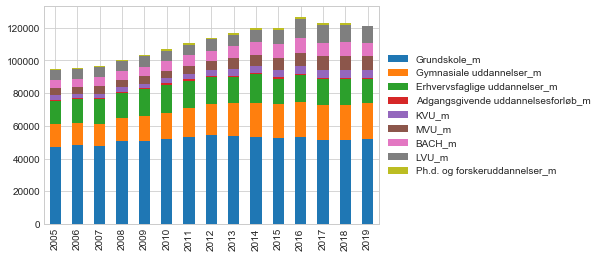

In [35]:

df_m.T.plot(kind = 'bar', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()




# Kvinder 
alder_k = np.array(data.iloc[817+z[0]:853+z[0],4])

#print(alder_m)

antal_tot_k = np.array(data.iloc[816+z,5:20])

#print(antal_tot_m)


In [36]:
df_k = pd.DataFrame(
    antal_tot_k,
    columns = years,
    index = uddannelse_k
)
#print(df_k)

# Drop
df_k.drop('Erhvervsfaglige grundforløb_k', inplace=True)
df_k.drop('Forberedende uddannelser_k',inplace=True)

df_k

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Grundskole_k,46642.0,47440.0,46876.0,49605.0,49778.0,51118.0,52042.0,52231.0,51324.0,50349.0,50415.0,50655.0,49199.0,48763.0,49180.0
Gymnasiale uddannelser_k,18804.0,18092.0,18508.0,18751.0,20087.0,20955.0,21966.0,23253.0,24154.0,25163.0,25204.0,25306.0,24836.0,25897.0,26680.0
Erhvervsfaglige uddannelser_k,16848.0,16381.0,16561.0,16693.0,16691.0,15528.0,15752.0,16783.0,16379.0,16563.0,15744.0,16955.0,16071.0,14333.0,11045.0
Adgangsgivende uddannelsesforløb_k,250.0,256.0,280.0,249.0,210.0,207.0,184.0,224.0,250.0,217.0,198.0,175.0,192.0,241.0,191.0
KVU_k,2301.0,2250.0,2647.0,2775.0,2655.0,2807.0,3207.0,3326.0,3635.0,3846.0,4009.0,4450.0,4516.0,4348.0,4458.0
MVU_k,11357.0,10613.0,9995.0,10007.0,10545.0,10348.0,10128.0,9952.0,11599.0,12522.0,13064.0,13417.0,13360.0,13612.0,13735.0
BACH_k,5984.0,5986.0,6548.0,6896.0,7650.0,8390.0,8014.0,8501.0,9435.0,9734.0,10004.0,11106.0,9916.0,10010.0,10202.0
LVU_k,6617.0,6659.0,7330.0,7170.0,7657.0,7480.0,8043.0,8678.0,9386.0,10149.0,11046.0,15162.0,13970.0,13207.0,13414.0
Ph.d. og forskeruddannelser_k,417.0,417.0,441.0,506.0,540.0,664.0,726.0,776.0,869.0,1020.0,1071.0,1078.0,1084.0,1024.0,0.0


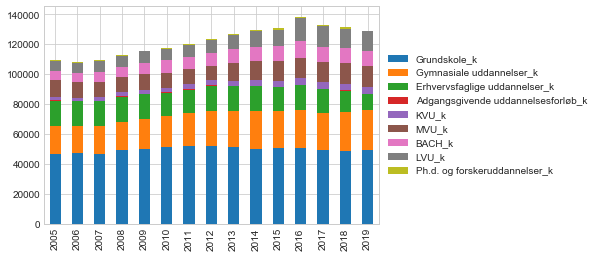

In [37]:
df_k.T.plot(kind = 'bar', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

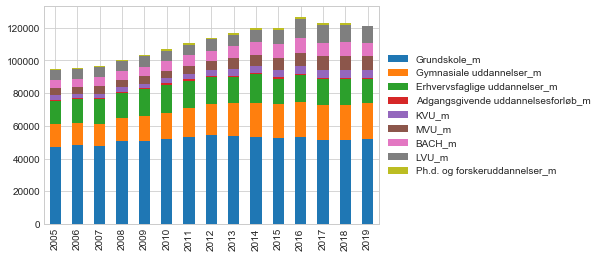

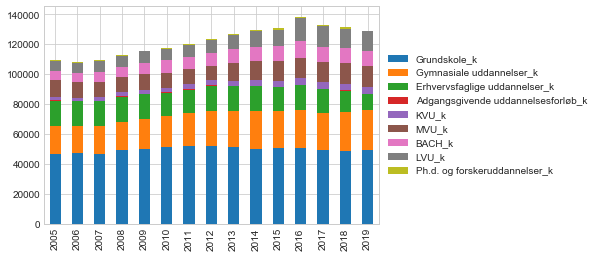

In [38]:
# Appending
df_mk = df_m.append(df_k)

df_mk

df_m.T.plot(kind = 'bar', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

df_k.T.plot(kind = 'bar', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()



In [39]:
i = np.array(range(15))
#print(i)
antal_test =  np.array(data.iloc[3:39,5+i])
antal = antal_test.transpose()
#print(antal)


#c = np.array(range(36))

x_1 = np.array(range(36))
x = sorted(x_1,reverse=True)



def v(x ,c = 36):
    return np.array(range(0, c-x))
def w(x):
    return sorted(v(x), reverse=True)
#print(w(0))

#def v:
#    if v>0:
#        return ()
#    if v < 0:
#        return
    


def antal_a_2005(x, i = 0):
    return np.array(data.iloc[3+v(x),5+i])


#def antal_a_2005(v, c = c, i = 0):
#    return np.array(data.iloc[3+c-v,5+i])


In [40]:
#Open the data file and taking a look at it
Data = 'Data.xlsx'
pd.read_excel(Data).head(5)

,"Uddannelsesaktivitet efter status, bopælsområde, køn, uddannelse, alder og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,Enhed: antal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
2,Fuldført,Hele landet,Mænd og kvinder i alt,H10 Grundskole,Alder i alt,93865.0,95634.0,94320.0,100198.0,100715.0,102939.0,105233.0,106509.0,104984.0,103470.0,102982.0,103751.0,100831.0,100202.0,101043.0
3,NaN,NaN,NaN,NaN,-5 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,29.0
4,NaN,NaN,NaN,NaN,6 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,81.0


In [41]:
#Removing the first two rows as they are useless.
df = pd.read_excel(Data, skiprows=2)


#Removing first 2 columns
drop_these = ['Unnamed: 0', 'Unnamed: 1']
df.drop(drop_these, axis=1, inplace=True) # axis = 1 -> columns, inplace=True -> changed, no copy made


In [42]:
#Renaming the columns
df.rename(columns = {'Unnamed: 2':'sex'}, inplace=True)
df.rename(columns = {'Unnamed: 3':'education'}, inplace=True)
df.rename(columns = {'Unnamed: 4':'age'}, inplace=True)

In [43]:
#Renaming years because having them as numbers can cause problems
#years = {}
#for i in range(2005,2019+1): # range from 2008 to but not including 2018
#    years[str(i)] = f'year{i}'
#df.rename(columns = years, inplace=True)


#find index of sex
total = df.loc[df["sex"]=="Mænd og kvinder i alt"].index
male = df.loc[df["sex"]=="Mænd"].index
female = df.loc[df["sex"]=="Kvinder"].index
#rename sec to total, male, and female
df["sex"][total] = "total"
df["sex"][male] = "male"
df["sex"][female] = "female"

In [44]:
#rename nan in sex to floats.
for i in range(0,len(df)):
    if type(df["sex"][i]) == str:
        x = df["sex"][i]
    else:
        df["sex"][i] = x

#rename nan in Education to floats
for i in range(0,len(df)):
    if type(df["education"][i]) == str:
        x = df["education"][i]
    else:
        df["education"][i] = x

In [61]:
#Formatting the dataframe so it's easier to work with
df_long = pd.melt(df,id_vars=["sex","education","age"], var_name="year",value_name="uddannelsesaktivitet")
#Checking data
print(df_long)

sex                        education          age  year  \
0       total                   H10 Grundskole  Alder i alt  2005   
1       total                   H10 Grundskole        -5 år  2005   
2       total                   H10 Grundskole         6 år  2005   
3       total                   H10 Grundskole         7 år  2005   
4       total                   H10 Grundskole         8 år  2005   
...       ...                              ...          ...   ...   
18340  female  H80 Ph.d. og forskeruddannelser        38 år  2019   
18341  female  H80 Ph.d. og forskeruddannelser        39 år  2019   
18342  female  H80 Ph.d. og forskeruddannelser       40 år-  2019   
18343  female  H80 Ph.d. og forskeruddannelser          NaN  2019   
18344  female  H80 Ph.d. og forskeruddannelser          NaN  2019   

       uddannelsesaktivitet  
0                   93865.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  
.

In [47]:
#Creating dropdown options
ALL = 'ALL'

def unique_sorted_values_plus_all(array):
    liste = array.values.tolist()
    unique = np.unique(liste)
    unique.sort()
    unique = unique.tolist()
    unique.insert(0,ALL)
    return unique

In [ ]:
#Defining what to show in table very likely there is an easier method, this was hell.
def filters(year, age, sex, education):
    output.clear_output()
    plot_output.clear_output()
    
    if (year == ALL) & (age == ALL) & (sex == ALL) & (education == ALL): # everything
        filters = df_long
    elif (age == ALL) & (sex == ALL) & (education == ALL) : # everything but year
        filters = df_long[df_long.year == year]
    elif (year == ALL) & (sex == ALL) & (education == ALL): # everything but age
        filters = df_long[df_long.age == age]
    elif (age == ALL) & (year == ALL) & (education == ALL): # everything but sex
        filters = df_long[df_long.sex == sex]
    elif (age == ALL) & (year == ALL) & (sex == ALL): # everything but education
        filters = df_long[df_long.education == education]
    elif (sex == ALL) & (education == ALL): # everything but year, age
        filters = df_long[(df_long.year == year) & (df_long.age == age)]
    elif (age == ALL) & (education == ALL): # everything but year, sex
        filters = df_long[(df_long.year == year) & (df_long.sex == sex)]
    elif (age == ALL) & (sex == ALL): # everything but year, education
        filters = df_long[(df_long.year == year) & (df_long.education == education)]
    elif (year == ALL) & (education == ALL): # everything but age sex
        filters = df_long[(df_long.age == age) & (df_long.sex == sex)]
    elif (year == ALL) & (sex == ALL): # everything but age education
        filters = df_long[(df_long.age == age) & (df_long.education == education)]
    elif (year == ALL) & (age == ALL): # everything but sex education
        filters = df_long[(df_long.sex == sex) & (df_long.education == education)]
    elif (year == ALL): # everything but age sex education
        filters = df_long[(df_long.age == age) & (df_long.sex == sex) & (df_long.education == education)]
    elif (age == ALL): # everything but year sex education
        filters = df_long[(df_long.year == year) & (df_long.sex == sex) & (df_long.education == education)]
    elif (sex == ALL): # everything but year age education
        filters = df_long[(df_long.year == year) & (df_long.age == age) & (df_long.education == education)]
    elif (education == ALL): # everything but year age sex
        filters = df_long[(df_long.year == year) & (df_long.age == age) & (df_long.sex == sex)]
    else:
        filters = df_long[(df_long.year == year) & (df_long.age == age) & (df_long.sex == sex) & (df_long.education == education)]
    
    with output:
        display(filters)
    with plot_output:
        sns.kdeplot(filters['uddannelsesaktivitet'], shade=True)
        plt.show()

In [ ]:
#Defining functions looking for changes.
def dropdown_year_eventhandler(change):
    filters(change.new, dropdown_age.value, dropdown_sex.value, dropdown_education.value)
def dropdown_age_eventhandler(change):
    filters(dropdown_year.value, change.new, dropdown_sex.value, dropdown_education.value)
def dropdown_sex_eventhandler(change):
    filters(dropdown_year.value, dropdown_age.value, change.new, dropdown_education.value)
def dropdown_education_eventhandler(change):
    filters(dropdown_year.value, dropdown_age.value, dropdown_sex.value, change.new)

In [60]:
# Generating dropdown menues
dropdown_year = widgets.Dropdown(options=unique_sorted_values_plus_all(df_long.year))
dropdown_age = widgets.Dropdown(options=unique_sorted_values_plus_all(df_long.age))
dropdown_sex = widgets.Dropdown(options=unique_sorted_values_plus_all(df_long.sex))
dropdown_education = widgets.Dropdown(options=unique_sorted_values_plus_all(df_long.education))

#Defining outputs
output = widgets.Output()
plot_output = widgets.Output()

In [59]:
#Observe changes in the dropdown.
dropdown_year.observe(
dropdown_year_eventhandler, names='value')
dropdown_age.observe(
dropdown_age_eventhandler, names='value')
dropdown_sex.observe(
dropdown_sex_eventhandler, names='value')
dropdown_education.observe(
dropdown_education_eventhandler, names='value')

In [58]:
#Display dropdown menus
display(dropdown_year)
display(dropdown_age)
display(dropdown_sex)
display(dropdown_education)

Dropdown(options=('ALL', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015…

Dropdown(options=('ALL', '-5 år', '10 år', '11 år', '12 år', '13 år', '14 år', '15 år', '16 år', '17 år', '18 …

Dropdown(options=('ALL', 'female', 'male', 'total'), value='ALL')

Dropdown(options=('ALL', 'H10 Grundskole', 'H15 Forberedende uddannelser', 'H20 Gymnasiale uddannelser', 'H29 …

In [57]:
#Display Table
display(output)
#Display graph
#The graph does not work if there are 1 or less total data points, some options have NaN and will break the graph.
display(plot_output)

Output()

Output()

In [55]:
# FIRST ITERATION OF THE GRAPH, WORKS BUT NOT VERY WELL

#def plot_e(df, sex, education, age): 
#    I = df['sex'] == sex
#    ax=df.loc[I,:].plot(x='year', y='uddannelsesaktivitet', style='-o', legend=False)

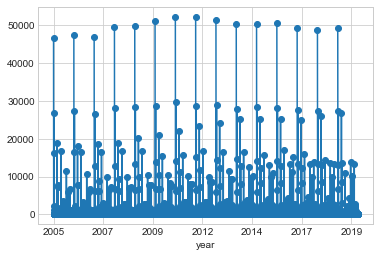

In [56]:
#widgets.interact(plot_e, 
#    df = widgets.fixed(df_long),
#    sex = widgets.Dropdown(description='sex', 
#                                    options=df_long.sex.unique(), 
#                                    value='female'),
#    education = widgets.Dropdown(description='education', options=df_long.education.unique(), value='H10 Grundskole'),
#    age = widgets.Dropdown(description='age', options=df_long.age.unique(), value='10 år')
#); 